In [1]:
import time, random
import numpy as np
# import pennylane as qml
# from qiskit import Aer, transpile, execute
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import random_clifford, Pauli, Statevector
import matplotlib.pyplot as plt

np.set_printoptions(precision=6, edgeitems=10, linewidth=150, suppress=True)

In [2]:
import qiskit
import itertools
from qiskit import *
from qiskit.quantum_info import Clifford, random_clifford
from qiskit.synthesis import synth_clifford_full
from qiskit.quantum_info import hellinger_fidelity as hf

from utils.pauli_checks import ChecksFinder, add_pauli_checks, add_meas_pauli_checks, add_linear_meas_pauli_checks,  search_for_pauli_list
from utils.pauli_checks import gen_initial_layout, gen_final_layout, complete_postprocess, filter_results

from utils.utils import norm_dict, total_counts
# from utils.vqe_utils import evaluation

In [3]:
qiskit.__version__

'1.1.0'

#### I. Calibrating $\tilde{f}$ in the noisy Clifford channel using hardware

In [4]:
total_trials = 10000
num_qubits = 6
def calibration_circuit(Clifford):
    qc = QuantumCircuit(num_qubits)
    
    clifford_circuit = Clifford.to_circuit()
    # qc.compose(clifford_circuit, qubits=[0,1,2,3], inplace=True)
    qc.compose(clifford_circuit, qubits=range(num_qubits), inplace=True)
    
    qc.measure_all()
    return qc

In [5]:
cali_C_list = []
for i in range(total_trials):
    # Clifford = random_clifford(4)
    Clifford = random_clifford(num_qubits)
    cali_C_list.append(Clifford)
    
cali_circs = []
for i in range(total_trials):
    circuit = calibration_circuit(cali_C_list[i])
    cali_circs.append(circuit)

In [6]:
print(cali_circs[0])

                                    ┌───┐┌───┐┌───┐                    ┌───┐»
   q_0: ──────X──────────────────■──┤ S ├┤ H ├┤ S ├──X──────────────■──┤ H ├»
        ┌───┐ │ ┌───┐┌───┐┌───┐  │  └───┘└───┘└───┘  │              │  ├───┤»
   q_1: ┤ S ├─┼─┤ X ├┤ S ├┤ H ├──┼───────────────────┼─────────■────┼──┤ S ├»
        └───┘ │ └─┬─┘└───┘└───┘  │                   │       ┌─┴─┐┌─┴─┐└───┘»
   q_2: ──────┼───┼─────────■────┼───────────────────X────■──┤ X ├┤ X ├──■──»
              │   │  ┌───┐  │    │                      ┌─┴─┐├───┤└───┘  │  »
   q_3: ──────┼───┼──┤ X ├──┼────┼──────────────────────┤ X ├┤ H ├───────┼──»
        ┌───┐ │   │  └─┬─┘  │    │  ┌───┐┌───┐          └───┘└───┘     ┌─┴─┐»
   q_4: ┤ S ├─┼───┼────┼────┼────┼──┤ X ├┤ H ├──■──────────────────────┤ X ├»
        └───┘ │   │    │  ┌─┴─┐┌─┴─┐└─┬─┘└───┘┌─┴─┐┌───┐               └───┘»
   q_5: ──────X───■────■──┤ X ├┤ X ├──■───────┤ X ├┤ Z ├────────────────────»
                          └───┘└───┘          └───┘└───┘        

Set noise model and topolgoy

In [7]:
# from qiskit_ibm_runtime import Session, Options, SamplerV2 as Sampler
from qiskit_ibm_runtime import Session, Sampler, Options
from qiskit_ibm_runtime.fake_provider import *
from qiskit_aer import AerSimulator
import qiskit_aer.noise as noise
from itertools import combinations

#service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q-ornl/anl/chm185")
# service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q/open/main")

# Make a noise model
fake_backend = FakeCairo()
# noise_model = NoiseModel.from_backend(fake_backend)

prob_1 = 0.002  # 1-qubit gate
prob_2 = 0.02   # 2-qubit gate

error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3', 'sx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

options = Options(optimization_level=2, resilience_level=1) # choose the proper levels on hardware
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    # "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}

#backend = service.get_backend("") 
#backend = "ibmq_qasm_simulator" # use the simulator for now
backend = AerSimulator()

inhomogeneous error rates (across qubits)

In [8]:
# from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
# from qiskit.providers.fake_provider import FakeHanoi
# from qiskit_aer.noise import NoiseModel
# from itertools import combinations
# import qiskit.providers.aer.noise as noise

# #service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q-ornl/anl/chm185")
# service = QiskitRuntimeService()

# fake_backend = FakeHanoi()

# # Specify Noisy qubits and their pairs
# noisy_qubits = [0, 1, 2, 3, 4, 5]
# noisy_pairs = list(combinations(noisy_qubits, 2))

# # Define the ranges for error rates
# min_prob_1, max_prob_1 = 0.0015, 0.0025  # Range for 1-qubit gate error rates
# min_prob_2, max_prob_2 = 0.015, 0.025  # Range for 2-qubit gate error rates

# # Calculate even portions of error rates
# error_rates_1 = [min_prob_1 + (max_prob_1 - min_prob_1) * i / (len(noisy_qubits) - 1) for i in range(len(noisy_qubits))]
# error_rates_2 = [min_prob_2 + (max_prob_2 - min_prob_2) * i / (len(noisy_pairs) - 1) for i in range(len(noisy_pairs))]

# print(error_rates_1)
# print(error_rates_2)
# # Create a noise model
# noise_model = noise.NoiseModel()

# # Assign error rates in ascending order
# for i, noisy_qbt in enumerate(noisy_qubits):
#     error_1 = noise.depolarizing_error(error_rates_1[i], 1)
#     noise_model.add_quantum_error(error_1, ['u1', 'u2', 'u3', 'sx', 'x'], [noisy_qbt])

# for i, noisy_pair in enumerate(noisy_pairs):
#     error_2 = noise.depolarizing_error(error_rates_2[i], 2)
#     noise_model.add_quantum_error(error_2, ['cx'], list(noisy_pair))
#     noise_model.add_quantum_error(error_2, ['cx'], list(reversed(noisy_pair)))
    
# options = Options(optimization_level=2, resilience_level=1) # choose the proper levels on hardware
# options.simulator = {
#     "noise_model": noise_model,
#     "basis_gates": fake_backend.configuration().basis_gates,
# #     "coupling_map": fake_backend.configuration().coupling_map,
#     "seed_simulator": 42
# }
# #backend = service.get_backend("") 
# backend = "ibmq_qasm_simulator" # use the simulator for now

In [9]:
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']
  Instructions with noise: ['x', 'sx', 'u2', 'cx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'sx', 'x', 'cx']


In [10]:
with Session(backend=backend) as session:
    sampler = Sampler(session=session, options=options)
    
    # define physical qubits to be used in the layout arguement
    job = sampler.run(cali_circs, shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")
    
    result = job.result()
    
    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

/Users/celsloaner/opt/anaconda3/envs/pcs_zne/lib/python3.9/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(
/var/folders/b4/nbfyyzvd3tlcp6vv5xyc9wpw0000gq/T/ipykernel_7908/4135206114.py:2: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session, options=options)


Job ID: 20374e9d-c212-4ac6-9db4-46916145114c
>>> Job Status: JobStatus.RUNNING


In [11]:
cali_b_lists = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits]: result.quasi_dists[i].binary_probabilities().get(key)})
    cali_b_lists.append(di)

In [12]:
len(cali_b_lists)

10000

In [13]:
cali_b_lists[-1]

{'011110': 0.0146484375,
 '110000': 0.021484375,
 '101110': 0.01171875,
 '101010': 0.0126953125,
 '100010': 0.0107421875,
 '100100': 0.0126953125,
 '000011': 0.0166015625,
 '001110': 0.01171875,
 '001010': 0.017578125,
 '000111': 0.0185546875,
 '001011': 0.0126953125,
 '011011': 0.0087890625,
 '001001': 0.01171875,
 '001111': 0.017578125,
 '110101': 0.013671875,
 '111011': 0.015625,
 '111101': 0.01171875,
 '111010': 0.0166015625,
 '111100': 0.021484375,
 '001000': 0.0224609375,
 '010100': 0.009765625,
 '001100': 0.0146484375,
 '101000': 0.017578125,
 '110011': 0.01171875,
 '101101': 0.017578125,
 '110010': 0.01171875,
 '101011': 0.009765625,
 '010110': 0.017578125,
 '010111': 0.015625,
 '010001': 0.0126953125,
 '011111': 0.0205078125,
 '010101': 0.015625,
 '000000': 0.01171875,
 '110001': 0.01171875,
 '011101': 0.0185546875,
 '000101': 0.0185546875,
 '010010': 0.0166015625,
 '100000': 0.0263671875,
 '111110': 0.015625,
 '000110': 0.0205078125,
 '111000': 0.01953125,
 '000010': 0.022460

In [14]:
def calibrating_f(cali_b_lists, cali_C_list, num_qubits):
    d = 2**num_qubits
    num_snapshots = len(cali_C_list)
    
    f_tilde = 0.
    for b_dict, clifford in zip(cali_b_lists, cali_C_list):
        F = computing_F(b_dict, clifford, num_qubits)
        f_tilde += np.real((d*F - 1) / (d - 1))
    
    return f_tilde / num_snapshots


def computing_F(b_dict, clifford, num_qubits):
    zero_state = state_reconstruction('0'*num_qubits)
    U = clifford.to_matrix()
    
    F = 0. + 0.j
    denom = 0.
    for b_state in list(b_dict.keys()):
        F += np.trace(zero_state @ U.T.conj() @ state_reconstruction(b_state) @ U) * b_dict.get(b_state)
        denom += b_dict.get(b_state)
    return F / denom


def state_reconstruction(b_str: str):
    '''
    '''
    zero_state = np.array([[1,0],[0,0]])
    one_state = np.array([[0,0], [0,1]])
    rho = [1]
    for i in b_str:
        state_i = zero_state if i=='0' else one_state
        rho = np.kron(rho, state_i)
    return rho

In [15]:
%%time

f_tilde = calibrating_f(cali_b_lists, cali_C_list, num_qubits)
print(f'The calibrated f_tilde is {f_tilde}; while the noiseless reference is {1/(2**num_qubits+1)}')

The calibrated f_tilde is 0.011729578993055557; while the noiseless reference is 0.015384615384615385
CPU times: user 23min 14s, sys: 6min 2s, total: 29min 17s
Wall time: 7min 22s


#### II. Perform the standard shadow experiments

In [16]:
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector

def construct_qcc_circuit(entanglers: list, truncation=None):
    '''This function defines the QCC ansatz circuit for VQE. Here we construct exponential blocks using
    entanglers from QMF state as a proof of principle demonstration.
    
    Args:
        entanglers: list storing Pauli words for construction of qcc_circuit.
        backend: statevector, qasm simulator or a real backend.
        truncation: a threshold number to truncate the blocks. Default: None.
    Returns:
        qcc_circuit
    '''
    if truncation != None:
        if len(entanglers) > truncation:
            num_blocks = truncation
        else:
            num_blocks = len(entanglers)
    else:
        num_blocks = len(entanglers)
    
    # p = ParameterVector('p', num_blocks)
    p = [0.0944527, 0.04799566, -0.0590973, -0.05908328, 0.04114604, 0.02695483, 0.02604318, 0.03485649]
    
    # num_qubits = len(entanglers[0])
    qcc_circuit = QuantumCircuit(num_qubits)
    for i in range(num_blocks):
        circuit = QuantumCircuit(num_qubits)
        key = entanglers[i]
        coupler_map = []
        # We first construct coupler_map according to the key.
        for j in range(num_qubits):
            if key[num_qubits-1-j] != 'I':
                coupler_map.append(j)
                
        # Then we construct the circuit.
        if len(coupler_map) == 1:
            # there is no CNOT gate.
            c = coupler_map[0]
            if key[num_qubits-1-c] == 'X':
                circuit.h(c)
                circuit.rz(p[i], c)
                circuit.h(c)
            elif key[num_qubits-1-c] == 'Y':
                circuit.rx(-np.pi/2, c)
                circuit.rz(p[i], c)
                circuit.rx(np.pi/2, c)
                
            qcc_circuit += circuit
        else:
            # Here we would need CNOT gate.
            for j in coupler_map:
                if key[num_qubits-1-j] == 'X':
                    circuit.h(j)
                elif key[num_qubits-1-j] == 'Y':
                    circuit.rx(-np.pi/2, j)
                    
            for j in range(len(coupler_map) - 1):
                circuit.cx(coupler_map[j], coupler_map[j+1])
                
            param_gate = QuantumCircuit(num_qubits)
            param_gate.rz(p[i], coupler_map[-1])
            
            #qcc_circuit += circuit + param_gate + circuit.inverse()
            qcc_circuit.compose(circuit, inplace=True)
            qcc_circuit.compose(param_gate, inplace=True)
            qcc_circuit.compose(circuit.inverse(), inplace=True)
    
    # Would the optimization level setting to 3 represent the best Qiksit optimization?
    # trans_circuit = transpile(qcc_circuit, backend=backend, optimization_level=3)
    
    return qcc_circuit

In [17]:
# define the ansatz circuit

# num_checks = 4
# num_qubits = 4
# total_qubits = num_checks + num_qubits
# def hydrogen_trial_circuit(num_qubits):
#     qc = QuantumCircuit(num_qubits)
#     # prepare the Hartree-Fock state
#     qc.x(0)
#     qc.x(1)
    
#     qc.rx(np.pi/2, 0)
#     qc.h(1)
#     qc.h(2)
#     qc.h(3)
    
#     qc.cx(0,1)
#     qc.cx(1,2)
#     qc.cx(2,3)
    
#     qc.rz(1.0, 3)
    
#     qc.cx(2,3)
#     qc.cx(1,2)
#     qc.cx(0,1)
    
#     qc.rx(-np.pi/2, 0)
#     qc.h(1)
#     qc.h(2)
#     qc.h(3)
    
#     return qc

# def generalized_trial_circuit(num_qubits, num_checks):
#     total_qubits = num_qubits + num_checks
#     qc = QuantumCircuit(total_qubits)
#     # Hartree-Fock state preparation for an even number of qubits
#     for i in range(num_qubits // 2):
#         qc.x(i)
    
#     # Generalized entanglement pattern
#     for i in range(num_qubits - 1):
#         qc.h(i)
#         qc.cx(i, i + 1)
    
#     qc.rz(1.0, num_qubits - 1)
    
#     for i in reversed(range(num_qubits - 1)):
#         qc.cx(i, i + 1)
#         qc.h(i)
    
#     return qc

def hf_circ(num_qubits, num_checks):
    total_qubits = num_qubits + num_checks
    
    hf_circuit = QuantumCircuit(total_qubits)
    hf_circuit.x(0)
    hf_circuit.x(3)
        
    entanglers = ['XXXXXY', 'XXXIYI', 'IXIXXY', 'IXIIYI', 'IXXIXY', 'XXIXYI', 'IIIXIY', 'XIYIII']

    parameterized_circuit = hf_circuit.compose(construct_qcc_circuit(entanglers))
    
    return parameterized_circuit

def hydrogen_shadow_circuit(Clifford, num_qubits):
    # qc = hydrogen_trial_circuit(num_qubits)
    # qc = generalized_trial_circuit(num_qubits, num_checks=0)
    qc = hf_circ(num_qubits, num_checks=0)
    
    clifford_circuit = Clifford.to_circuit()
    # qc.compose(clifford_circuit, qubits=[0,1,2,3], inplace=True)
    qc.compose(clifford_circuit, qubits=range(num_qubits), inplace=True)
    qc.measure_all()
    return qc

def hydrogen_shadow_PCS_circuit(Clifford, num_qubits, num_checks):
    total_qubits = num_qubits + num_checks
    # qc = hydrogen_trial_circuit(total_qubits)
    # qc = generalized_trial_circuit(num_qubits, num_checks)
    qc = hf_circ(num_qubits, num_checks)

    clif_qc = Clifford.to_circuit()
    
    characters = ['I', 'Z']
    strings = [''.join(p) for p in itertools.product(characters, repeat=num_qubits)]
    
    test_finder = ChecksFinder(num_qubits, clif_qc)
    p1_list = []
    for string in strings:
        string_list = list(string)
        result = test_finder.find_checks_sym(pauli_group_elem = string_list)
        #print(result.p1_str, result.p2_str)
        p1_list.append([result.p1_str, result.p2_str])
        
    sorted_list = sorted(p1_list, key=lambda s: s[1].count('I'))
    pauli_list = sorted_list[-num_qubits -1:-1]
    
    #
    initial_layout = {}
    for i in range(0, num_qubits):
        initial_layout[i] = [i]

    final_layout = {}
    for i in range(0, num_qubits):
        final_layout[i] = [i]
        
    #add pauli check on two sides:
    #specify the left and right pauli strings
    pcs_qc_list = []
    sign_list = []
    pl_list = []
    pr_list = []

    for i in range(0, num_checks):
        pl = pauli_list[i][0][2:]
        pr = pauli_list[i][1][2:]
        if i == 0:
            temp_qc = add_pauli_checks(clif_qc, pl, pr, initial_layout, final_layout, False, False, False, False, False)
            save_qc = add_pauli_checks(clif_qc, pl, pr, initial_layout, final_layout, False, False, False, False, False)
            prev_qc = temp_qc
        else:
            temp_qc = add_pauli_checks(prev_qc, pl, pr, initial_layout, final_layout, False, False, False, False, False)
            save_qc = add_pauli_checks(prev_qc, pl, pr, initial_layout, final_layout, False, False, False, False, False) 
            prev_qc = temp_qc
        pl_list.append(pl)
        pr_list.append(pr)
        sign_list.append(pauli_list[i][0][:2])
        pcs_qc_list.append(save_qc)

    qc.barrier()
    qc.compose(pcs_qc_list[-1], qubits=[i for i in range(0, total_qubits)], inplace=True)
    qc.barrier()
    
    qc.measure_all()
    return sign_list, qc

In [18]:
num_qubits = 6
num_checks = 4
C_list = []
for i in range(total_trials):
    # Clifford = random_clifford(4)
    Clifford = random_clifford(num_qubits)
    C_list.append(Clifford)
circs_list = []
signs_list = []
for check_id in range(1, num_checks + 1):
    print(check_id, i)
    circs = []
    signs = []
    for i in range(total_trials):
        sign, circuit = hydrogen_shadow_PCS_circuit(C_list[i], num_qubits, check_id)
        signs.append(sign)
        circs.append(circuit)
    circs_list.append(circs)
    signs_list.append(signs)
    
orign_circs = []
for i in range(total_trials):
    circuit = hydrogen_shadow_circuit(C_list[i], num_qubits)
    orign_circs.append(circuit)

1 9999
2 9999
3 9999
4 9999


In [19]:
print(len(orign_circs))
print(orign_circs[0])

10000
        ┌───┐┌──────────┐                                                   »
   q_0: ┤ X ├┤ Rx(-π/2) ├──■────────────────────────────────────────────────»
        ├───┤└──────────┘┌─┴─┐                                              »
   q_1: ┤ H ├────────────┤ X ├──■───────────────────────────────────────────»
        ├───┤            └───┘┌─┴─┐                                         »
   q_2: ┤ H ├─────────────────┤ X ├──■──────────────────────────────────────»
        ├───┤   ┌───┐         └───┘┌─┴─┐                                    »
   q_3: ┤ X ├───┤ H ├──────────────┤ X ├──■──────────────────────────────■──»
        ├───┤   └───┘              └───┘┌─┴─┐                          ┌─┴─┐»
   q_4: ┤ H ├───────────────────────────┤ X ├──■────────────────────■──┤ X ├»
        ├───┤                           └───┘┌─┴─┐┌──────────────┐┌─┴─┐├───┤»
   q_5: ┤ H ├────────────────────────────────┤ X ├┤ Rz(0.094453) ├┤ X ├┤ H ├»
        └───┘                                └───┘└───────

In [20]:
circs_list[0][-1].draw()

┌───┐┌──────────┐                                                   »
   q_0: ┤ X ├┤ Rx(-π/2) ├──■────────────────────────────────────────────────»
        ├───┤└──────────┘┌─┴─┐                                              »
   q_1: ┤ H ├────────────┤ X ├──■───────────────────────────────────────────»
        ├───┤            └───┘┌─┴─┐                                         »
   q_2: ┤ H ├─────────────────┤ X ├──■──────────────────────────────────────»
        ├───┤   ┌───┐         └───┘┌─┴─┐                                    »
   q_3: ┤ X ├───┤ H ├──────────────┤ X ├──■──────────────────────────────■──»
        ├───┤   └───┘              └───┘┌─┴─┐                          ┌─┴─┐»
   q_4: ┤ H ├───────────────────────────┤ X ├──■────────────────────■──┤ X ├»
        ├───┤                           └───┘┌─┴─┐┌──────────────┐┌─┴─┐├───┤»
   q_5: ┤ H ├────────────────────────────────┤ X ├┤ Rz(0.094453) ├┤ X ├┤ H ├»
        └───┘                                └───┘└──────────────┘└───┘└───┘»
   q_6: ────────────────────────────────────────────────────────────────────»
                                                                            »
meas: 7/════════════════════════════════════════════════════════════════════»
                                                                            »
«                       ┌─────────┐┌──────────┐                               »
«   q_0: ────────────■──┤ Rx(π/2) ├┤ Rx(-π/2) ├───────────────────────────────»
«                  ┌─┴─┐└──┬───┬──┘├──────────┤                               »
«   q_1: ───────■──┤ X ├───┤ H ├───┤ Rx(-π/2) ├──■────────────────────────────»
«             ┌─┴─┐├───┤   ├───┤   └──────────┘  │                            »
«   q_2: ──■──┤ X ├┤ H ├───┤ H ├─────────────────┼────────────────────────────»
«        ┌─┴─┐├───┤├───┤   └───┘               ┌─┴─┐                          »
«   q_3: ┤ X ├┤ H ├┤ H ├───────────────────────┤ X ├──■───────────────────────»
«        ├───┤├───┤└───┘                       └───┘┌─┴─┐                     »
«   q_4: ┤ H ├┤ H ├─────────────────────────────────┤ X ├──■──────────────────»
«        ├───┤└───┘                                 └───┘┌─┴─┐┌──────────────┐»
«   q_5: ┤ H ├───────────────────────────────────────────┤ X ├┤ Rz(0.047996) ├»
«        └───┘                                           └───┘└──────────────┘»
«   q_6: ─────────────────────────────────────────────────────────────────────»
«                                                                             »
«meas: 7/═════════════════════════════════════════════════════════════════════»
«                                                                             »
«                                                                            »
«   q_0: ─────────────────────────────────■──────────────────────────────────»
«                       ┌─────────┐┌───┐┌─┴─┐                                »
«   q_1: ────────────■──┤ Rx(π/2) ├┤ H ├┤ X ├──■─────────────────────────────»
«                    │  └─────────┘└───┘└───┘┌─┴─┐                           »
«   q_2: ────────────┼───────────────────────┤ X ├──■─────────────────────■──»
«                  ┌─┴─┐   ┌───┐   ┌───┐     └───┘  │                     │  »
«   q_3: ───────■──┤ X ├───┤ H ├───┤ H ├────────────┼─────────────────────┼──»
«             ┌─┴─┐├───┤   ├───┤   └───┘          ┌─┴─┐┌───────────────┐┌─┴─┐»
«   q_4: ──■──┤ X ├┤ H ├───┤ H ├──────────────────┤ X ├┤ Rz(-0.059097) ├┤ X ├»
«        ┌─┴─┐├───┤├───┤   └───┘                  └───┘└───────────────┘└───┘»
«   q_5: ┤ X ├┤ H ├┤ H ├─────────────────────────────────────────────────────»
«        └───┘└───┘└───┘                                                     »
«   q_6: ────────────────────────────────────────────────────────────────────»
«                                                                            »
«meas: 7/════════════════════════════════════════════════════════════════════»
«                                                         

In [21]:
def filter_results_reindex(dictionary, qubits, indexes, sign_list):
    new_dict = {}
    for key in dictionary.keys():
        new_key = ''
        for i in range(len(key)):
            meas_index = i
#             if i < len(sign_list):
#                 print(key, "index", i, key[i], sign_list[meas_index])
            if meas_index in indexes and key[i] == sign_list[meas_index]:
                #the key equals the sign, keep
                new_key = ''
                break
            if meas_index not in indexes:
                new_key += key[i]
        if new_key != '':
            new_dict[new_key] = dictionary[key]
    return new_dict

In [22]:
num_qubits

6

In [23]:
b_lists_filtered = []
check_id = 1
# Submit hardware jobs via Qiskit Runtime;

with Session(backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    # same as the calibration process
    job = sampler.run(circs_list[check_id-1], shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")

    result = job.result()

    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

b_lists_check = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + check_id]: result.quasi_dists[i].binary_probabilities().get(key)})
    b_lists_check.append(di)


filtered_b_lists = []
for i in range(total_trials):
    bit_list = ['1' if i == '+1' else '0' for i in signs_list[check_id-1][i][check_id - 1::-1]]
#     print(bit_list)
    filted_dist = filter_results_reindex(b_lists_check[i], num_qubits, [j for j in range(0, check_id)], bit_list)
    print(total_counts(filted_dist))
    filtered_b_lists.append(filted_dist)
b_lists_filtered.append(filtered_b_lists)


/var/folders/b4/nbfyyzvd3tlcp6vv5xyc9wpw0000gq/T/ipykernel_7908/173291808.py:6: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session, options=options)


0.857421875
0.7958984375
0.857421875
0.837890625
0.8330078125
0.7998046875
0.853515625
0.830078125
0.8720703125
0.8857421875
0.8388671875
0.8662109375
0.794921875
0.7919921875
0.8466796875
0.7939453125
0.80859375
0.8408203125
0.8701171875
0.814453125
0.8115234375
0.8095703125
0.8017578125
0.88671875
0.869140625
0.8291015625
0.82421875
0.8583984375
0.8427734375
0.8466796875
0.8662109375
0.8115234375
0.83984375
0.86328125
0.896484375
0.8359375
0.8173828125
0.837890625
0.8076171875
0.8359375
0.900390625
0.8154296875
0.869140625
0.845703125
0.8740234375
0.8623046875
0.8271484375
0.8271484375
0.8466796875
0.8583984375
0.8935546875
0.8662109375
0.87890625
0.787109375
0.80078125
0.8701171875
0.82421875
0.8359375
0.841796875
0.8515625
0.89453125
0.8017578125
0.7958984375
0.90625
0.822265625
0.9228515625
0.828125
0.8916015625
0.9228515625
0.8232421875
0.8779296875
0.8896484375
0.8388671875
0.8720703125
0.9208984375
0.8408203125
0.884765625
0.8837890625
0.8974609375
0.80859375
0.931640625
0.8945

0.8125
0.921875
0.865234375
0.8779296875
0.8369140625
0.802734375
0.8779296875
0.837890625
0.8642578125
0.84765625
0.8427734375
0.7744140625
0.912109375
0.8525390625
0.912109375
0.9287109375
0.8876953125
0.8466796875
0.8935546875
0.8193359375
0.849609375
0.9189453125
0.7744140625
0.8291015625
0.8916015625
0.7939453125
0.80078125
0.853515625
0.8857421875
0.80859375
0.8251953125
0.859375
0.841796875
0.837890625
0.8779296875
0.9208984375
0.8369140625
0.8896484375
0.841796875
0.8720703125
0.8486328125
0.8369140625
0.8857421875
0.8955078125
0.87109375
0.8642578125
0.8671875
0.8408203125
0.8271484375
0.8466796875
0.8701171875
0.8759765625
0.8349609375
0.87109375
0.8330078125
0.8935546875
0.8330078125
0.8076171875
0.8173828125
0.8076171875
0.859375
0.8681640625
0.8515625
0.84375
0.828125
0.8203125
0.8837890625
0.8740234375
0.81640625
0.8408203125
0.8544921875
0.791015625
0.8876953125
0.9111328125
0.830078125
0.822265625
0.8701171875
0.8505859375
0.861328125
0.91796875
0.8994140625
0.877929687

0.9189453125
0.8818359375
0.900390625
0.802734375
0.90234375
0.8515625
0.7890625
0.8798828125
0.8369140625
0.8896484375
0.86328125
0.884765625
0.798828125
0.8291015625
0.818359375
0.890625
0.822265625
0.890625
0.8173828125
0.890625
0.869140625
0.8115234375
0.7978515625
0.830078125
0.849609375
0.8173828125
0.85546875
0.8837890625
0.7939453125
0.890625
0.8984375
0.8193359375
0.830078125
0.8291015625
0.89453125
0.8642578125
0.857421875
0.8310546875
0.83203125
0.83984375
0.84765625
0.892578125
0.8994140625
0.85546875
0.85546875
0.908203125
0.8955078125
0.86328125
0.87109375
0.8701171875
0.8310546875
0.8759765625
0.8974609375
0.91796875
0.919921875
0.828125
0.8349609375
0.8564453125
0.853515625
0.8310546875
0.8427734375
0.908203125
0.8671875
0.896484375
0.869140625
0.892578125
0.8720703125
0.86328125
0.8994140625
0.89453125
0.8349609375
0.794921875
0.8330078125
0.83203125
0.828125
0.9150390625
0.904296875
0.857421875
0.8837890625
0.8076171875
0.837890625
0.8671875
0.83984375
0.79296875
0.84

0.8408203125
0.8427734375
0.9052734375
0.8232421875
0.8603515625
0.857421875
0.794921875
0.8505859375
0.873046875
0.810546875
0.82421875
0.8876953125
0.845703125
0.8642578125
0.8935546875
0.8857421875
0.865234375
0.857421875
0.84765625
0.8408203125
0.869140625
0.8095703125
0.845703125
0.83203125
0.9365234375
0.8564453125
0.849609375
0.8994140625
0.9033203125
0.82421875
0.8779296875
0.9072265625
0.8212890625
0.8369140625
0.8466796875
0.8505859375
0.8330078125
0.830078125
0.8955078125
0.818359375
0.9169921875
0.9111328125
0.9150390625
0.8681640625
0.875
0.873046875
0.8759765625
0.9248046875
0.8759765625
0.8447265625
0.7978515625
0.8701171875
0.900390625
0.8134765625
0.8125
0.8583984375
0.8271484375
0.810546875
0.84375
0.8671875
0.79296875
0.85546875
0.90234375
0.8671875
0.8125
0.798828125
0.8486328125
0.830078125
0.8544921875
0.8662109375
0.8125
0.9052734375
0.853515625
0.8544921875
0.8955078125
0.9033203125
0.8564453125
0.9140625
0.8759765625
0.9033203125
0.8515625
0.8505859375
0.872070

0.9052734375
0.8369140625
0.9384765625
0.8896484375
0.8291015625
0.826171875
0.849609375
0.912109375
0.88671875
0.8154296875
0.859375
0.81640625
0.8076171875
0.85546875
0.8544921875
0.8408203125
0.8427734375
0.9169921875
0.8359375
0.8369140625
0.8916015625
0.8525390625
0.912109375
0.837890625
0.884765625
0.896484375
0.822265625
0.8447265625
0.828125
0.9052734375
0.9091796875
0.8408203125
0.88671875
0.80078125
0.822265625
0.8427734375
0.810546875
0.890625
0.8125
0.8056640625
0.8681640625
0.8662109375
0.8583984375
0.841796875
0.84765625
0.87890625
0.826171875
0.8154296875
0.912109375
0.8974609375
0.869140625
0.8193359375
0.91015625
0.8740234375
0.8662109375
0.873046875
0.896484375
0.80078125
0.8603515625
0.880859375
0.8310546875
0.873046875
0.8828125
0.9072265625
0.7900390625
0.8642578125
0.826171875
0.875
0.880859375
0.833984375
0.8505859375
0.9189453125
0.8017578125
0.91015625
0.91015625
0.8701171875
0.8818359375
0.8388671875
0.8662109375
0.8271484375
0.919921875
0.8427734375
0.8427734

In [24]:
check_id = 2
# Submit hardware jobs via Qiskit Runtime;

with Session(backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    # same as the calibration process
    job = sampler.run(circs_list[check_id-1], shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")

    result = job.result()

    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

b_lists_check = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + check_id]: result.quasi_dists[i].binary_probabilities().get(key)})
    b_lists_check.append(di)


filtered_b_lists = []
for i in range(total_trials):
    bit_list = ['1' if i == '+1' else '0' for i in signs_list[check_id-1][i][check_id - 1::-1]]
#     print(bit_list)
    filted_dist = filter_results_reindex(b_lists_check[i], num_qubits, [j for j in range(0, check_id)], bit_list)
    print(total_counts(filted_dist))
    filtered_b_lists.append(filted_dist)
b_lists_filtered.append(filtered_b_lists)


/var/folders/b4/nbfyyzvd3tlcp6vv5xyc9wpw0000gq/T/ipykernel_7908/2718255842.py:5: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session, options=options)


Job ID: ac9a7237-8fb8-442a-877a-165b937335ca
>>> Job Status: JobStatus.RUNNING
0.755859375
0.6552734375
0.716796875
0.712890625
0.724609375
0.72265625
0.712890625
0.716796875
0.7412109375
0.7568359375
0.7001953125
0.7509765625
0.7021484375
0.7109375
0.7275390625
0.66015625
0.720703125
0.666015625
0.7568359375
0.681640625
0.724609375
0.69921875
0.6826171875
0.7353515625
0.712890625
0.703125
0.705078125
0.6982421875
0.732421875
0.728515625
0.7666015625
0.6748046875
0.7099609375
0.7578125
0.7255859375
0.7060546875
0.7314453125
0.703125
0.724609375
0.6728515625
0.7578125
0.7333984375
0.7587890625
0.7197265625
0.7607421875
0.7490234375
0.6923828125
0.732421875
0.759765625
0.693359375
0.755859375
0.7099609375
0.7138671875
0.623046875
0.716796875
0.765625
0.755859375
0.671875
0.7353515625
0.740234375
0.7822265625
0.7216796875
0.703125
0.755859375
0.76171875
0.865234375
0.7431640625
0.7490234375
0.765625
0.6943359375
0.7587890625
0.798828125
0.7705078125
0.70703125
0.7841796875
0.755859375
0.7

0.7236328125
0.720703125
0.734375
0.70703125
0.744140625
0.7109375
0.7470703125
0.7587890625
0.677734375
0.84375
0.8115234375
0.7421875
0.7998046875
0.8466796875
0.7607421875
0.740234375
0.6904296875
0.6865234375
0.755859375
0.798828125
0.7529296875
0.73046875
0.6767578125
0.6962890625
0.80078125
0.7509765625
0.6982421875
0.7744140625
0.7060546875
0.7607421875
0.794921875
0.765625
0.7041015625
0.7392578125
0.7470703125
0.6875
0.7080078125
0.751953125
0.748046875
0.751953125
0.7744140625
0.841796875
0.73046875
0.76953125
0.703125
0.7216796875
0.794921875
0.7392578125
0.751953125
0.75
0.748046875
0.728515625
0.6845703125
0.740234375
0.7548828125
0.703125
0.7841796875
0.7431640625
0.7578125
0.71875
0.76953125
0.7353515625
0.6806640625
0.720703125
0.7451171875
0.8046875
0.7451171875
0.7060546875
0.76953125
0.6943359375
0.73046875
0.71484375
0.736328125
0.6650390625
0.75390625
0.7939453125
0.7978515625
0.748046875
0.796875
0.728515625
0.748046875
0.7646484375
0.76171875
0.791015625
0.807617

0.7421875
0.794921875
0.755859375
0.7041015625
0.734375
0.693359375
0.732421875
0.7548828125
0.71875
0.8603515625
0.69140625
0.7119140625
0.6962890625
0.7265625
0.7236328125
0.71875
0.822265625
0.771484375
0.8291015625
0.71484375
0.7646484375
0.748046875
0.7255859375
0.7529296875
0.7333984375
0.7138671875
0.8095703125
0.7373046875
0.7734375
0.7705078125
0.748046875
0.7041015625
0.751953125
0.744140625
0.7275390625
0.80078125
0.8251953125
0.74609375
0.77734375
0.734375
0.748046875
0.7626953125
0.76953125
0.703125
0.71875
0.7626953125
0.76953125
0.689453125
0.7197265625
0.73828125
0.7333984375
0.69921875
0.84765625
0.7685546875
0.7451171875
0.6650390625
0.6865234375
0.767578125
0.6611328125
0.7099609375
0.7578125
0.79296875
0.7080078125
0.7421875
0.650390625
0.7451171875
0.7392578125
0.7255859375
0.701171875
0.69921875
0.7236328125
0.7197265625
0.6748046875
0.7099609375
0.76953125
0.70703125
0.7421875
0.7333984375
0.80078125
0.703125
0.7158203125
0.69921875
0.759765625
0.732421875
0.7382

0.7744140625
0.740234375
0.732421875
0.798828125
0.697265625
0.7255859375
0.7607421875
0.67578125
0.6875
0.6962890625
0.671875
0.7861328125
0.693359375
0.78125
0.73046875
0.763671875
0.6923828125
0.6953125
0.7236328125
0.763671875
0.7646484375
0.6943359375
0.7646484375
0.73828125
0.7548828125
0.7314453125
0.748046875
0.75
0.7529296875
0.720703125
0.7353515625
0.701171875
0.736328125
0.7001953125
0.712890625
0.759765625
0.69921875
0.7724609375
0.74609375
0.7607421875
0.744140625
0.755859375
0.755859375
0.7529296875
0.73046875
0.7685546875
0.7021484375
0.6689453125
0.7548828125
0.7490234375
0.7392578125
0.8232421875
0.78515625
0.7275390625
0.736328125
0.7060546875
0.6962890625
0.7353515625
0.6875
0.728515625
0.806640625
0.826171875
0.7685546875
0.7841796875
0.7041015625
0.7021484375
0.8017578125
0.7080078125
0.736328125
0.7236328125
0.7001953125
0.7490234375
0.7314453125
0.6875
0.7255859375
0.71484375
0.7119140625
0.7470703125
0.6884765625
0.720703125
0.7109375
0.7080078125
0.716796875
0

0.6845703125
0.7392578125
0.724609375
0.7294921875
0.7255859375
0.7255859375
0.734375
0.7548828125
0.6982421875
0.7197265625
0.71484375
0.8037109375
0.658203125
0.7177734375
0.728515625
0.7099609375
0.712890625
0.7421875
0.7578125
0.74609375
0.775390625
0.79296875
0.830078125
0.732421875
0.7177734375
0.73828125
0.75390625
0.708984375
0.7099609375
0.693359375
0.7373046875
0.6630859375
0.703125
0.794921875
0.806640625
0.7392578125
0.787109375
0.7451171875
0.720703125
0.71484375
0.7490234375
0.701171875
0.75
0.7451171875
0.7099609375
0.6962890625
0.7333984375
0.7802734375
0.7587890625
0.72265625
0.78515625
0.7392578125
0.748046875
0.7158203125
0.7958984375
0.7255859375
0.73046875
0.693359375
0.6962890625
0.7353515625
0.7763671875
0.6650390625
0.8115234375
0.7373046875
0.736328125
0.720703125
0.7509765625
0.6943359375
0.7255859375
0.7529296875
0.6982421875
0.71484375
0.8291015625
0.7578125
0.73828125
0.720703125
0.806640625
0.7275390625
0.708984375
0.728515625
0.7080078125
0.7236328125
0.7

0.748046875
0.7099609375
0.7607421875
0.7314453125
0.7158203125
0.7451171875
0.8154296875
0.6669921875
0.708984375
0.75
0.748046875
0.72265625
0.7734375
0.697265625
0.7373046875
0.703125
0.7666015625
0.681640625
0.7412109375
0.6845703125
0.77734375
0.7109375
0.7177734375
0.71875
0.69140625
0.73046875
0.73828125
0.7041015625
0.814453125
0.8701171875
0.7314453125
0.751953125
0.7607421875
0.763671875
0.6953125
0.7958984375
0.7119140625
0.751953125
0.7158203125
0.755859375
0.744140625
0.7314453125
0.736328125
0.69921875
0.7412109375
0.8193359375
0.7529296875
0.70703125
0.7626953125
0.771484375
0.740234375
0.7626953125
0.734375
0.77734375
0.763671875
0.7900390625
0.6884765625
0.70703125
0.7451171875
0.7880859375
0.69921875
0.7470703125
0.75
0.7880859375
0.748046875
0.71484375
0.72265625
0.71484375
0.7060546875
0.779296875
0.734375
0.7978515625
0.6767578125
0.736328125
0.7666015625
0.685546875
0.744140625
0.6943359375
0.7412109375
0.7236328125
0.7724609375
0.7509765625
0.7294921875
0.7060546

0.69921875
0.767578125
0.7373046875
0.6845703125
0.705078125
0.75
0.7705078125
0.7138671875
0.7255859375
0.7626953125
0.734375
0.6865234375
0.69921875
0.7158203125
0.7041015625
0.708984375
0.77734375
0.6923828125
0.705078125
0.724609375
0.7578125
0.673828125
0.7783203125
0.732421875
0.70703125
0.796875
0.72265625
0.693359375
0.7529296875
0.7119140625
0.7744140625
0.703125
0.7822265625
0.73046875
0.7841796875
0.7919921875
0.70703125
0.701171875
0.685546875
0.7333984375
0.771484375
0.748046875
0.7294921875
0.76171875
0.8017578125
0.7412109375
0.7578125
0.6787109375
0.728515625
0.6708984375
0.775390625
0.755859375
0.7724609375
0.8095703125
0.7177734375
0.771484375
0.7529296875
0.73046875
0.7099609375
0.7958984375
0.755859375
0.765625
0.8017578125
0.77734375
0.7392578125
0.71875
0.70703125
0.685546875
0.7529296875
0.6962890625
0.755859375
0.7841796875
0.75
0.7109375
0.73046875
0.76953125
0.763671875
0.7783203125
0.7255859375
0.708984375
0.7138671875
0.75390625
0.677734375
0.7216796875
0.75

In [25]:

check_id = 3
# Submit hardware jobs via Qiskit Runtime;

with Session(backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    # same as the calibration process
    job = sampler.run(circs_list[check_id-1], shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")

    result = job.result()

    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

b_lists_check = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + check_id]: result.quasi_dists[i].binary_probabilities().get(key)})
    b_lists_check.append(di)


filtered_b_lists = []
for i in range(total_trials):
    bit_list = ['1' if i == '+1' else '0' for i in signs_list[check_id-1][i][check_id - 1::-1]]
#     print(bit_list)
    filted_dist = filter_results_reindex(b_lists_check[i], num_qubits, [j for j in range(0, check_id)], bit_list)
    print(total_counts(filted_dist))
    filtered_b_lists.append(filted_dist)
b_lists_filtered.append(filtered_b_lists)


/var/folders/b4/nbfyyzvd3tlcp6vv5xyc9wpw0000gq/T/ipykernel_7908/2813568925.py:5: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session, options=options)


Job ID: 244f5243-a1ba-44f1-b71b-16badd022fe3
>>> Job Status: JobStatus.RUNNING
0.6728515625
0.5400390625
0.6650390625
0.6201171875
0.6396484375
0.646484375
0.619140625
0.6416015625
0.6484375
0.623046875
0.6083984375
0.63671875
0.5771484375
0.626953125
0.67578125
0.6123046875
0.6005859375
0.5712890625
0.66015625
0.6201171875
0.6376953125
0.58984375
0.57421875
0.5712890625
0.6396484375
0.6103515625
0.599609375
0.583984375
0.6591796875
0.6552734375
0.7001953125
0.599609375
0.6416015625
0.66796875
0.638671875
0.6044921875
0.6591796875
0.6337890625
0.6396484375
0.6005859375
0.6416015625
0.6396484375
0.67578125
0.6748046875
0.66015625
0.6787109375
0.58984375
0.61328125
0.662109375
0.630859375
0.6689453125
0.6298828125
0.6162109375
0.5703125
0.642578125
0.689453125
0.6484375
0.5771484375
0.6162109375
0.6083984375
0.6748046875
0.6142578125
0.6103515625
0.677734375
0.6591796875
0.7529296875
0.6640625
0.6298828125
0.7060546875
0.6005859375
0.6572265625
0.654296875
0.6416015625
0.62109375
0.66796

0.6396484375
0.6884765625
0.6953125
0.6357421875
0.60546875
0.666015625
0.630859375
0.6279296875
0.6455078125
0.6435546875
0.603515625
0.6796875
0.62109375
0.7041015625
0.6806640625
0.62890625
0.7255859375
0.646484375
0.6171875
0.662109375
0.6337890625
0.6123046875
0.63671875
0.671875
0.6357421875
0.595703125
0.6435546875
0.7197265625
0.6171875
0.595703125
0.62109375
0.6279296875
0.697265625
0.658203125
0.6650390625
0.6962890625
0.6591796875
0.662109375
0.6162109375
0.6337890625
0.640625
0.6298828125
0.6337890625
0.6572265625
0.654296875
0.619140625
0.6337890625
0.662109375
0.607421875
0.6611328125
0.6787109375
0.630859375
0.6455078125
0.6455078125
0.6591796875
0.6171875
0.6640625
0.6767578125
0.6650390625
0.6953125
0.6279296875
0.720703125
0.7412109375
0.6259765625
0.6884765625
0.6875
0.66015625
0.63671875
0.62109375
0.6572265625
0.640625
0.66796875
0.6103515625
0.6005859375
0.6162109375
0.6357421875
0.6455078125
0.6025390625
0.580078125
0.6943359375
0.63671875
0.63671875
0.6025390625

0.6337890625
0.62109375
0.6337890625
0.619140625
0.6982421875
0.6279296875
0.65625
0.7236328125
0.703125
0.6455078125
0.640625
0.65234375
0.65625
0.66015625
0.666015625
0.7255859375
0.6826171875
0.6455078125
0.6220703125
0.6103515625
0.6572265625
0.654296875
0.634765625
0.6875
0.6396484375
0.6337890625
0.5869140625
0.732421875
0.615234375
0.6796875
0.6552734375
0.6455078125
0.62890625
0.6484375
0.6015625
0.6484375
0.609375
0.6064453125
0.6787109375
0.638671875
0.576171875
0.603515625
0.642578125
0.6455078125
0.69921875
0.6865234375
0.6474609375
0.6396484375
0.703125
0.640625
0.6962890625
0.6845703125
0.69921875
0.67578125
0.7001953125
0.6044921875
0.638671875
0.609375
0.6953125
0.63671875
0.611328125
0.658203125
0.6162109375
0.63671875
0.6318359375
0.6474609375
0.66015625
0.6806640625
0.740234375
0.6572265625
0.6279296875
0.6298828125
0.6240234375
0.59375
0.689453125
0.7001953125
0.5947265625
0.7646484375
0.6318359375
0.6748046875
0.6142578125
0.5849609375
0.6591796875
0.6259765625
0.6

0.6240234375
0.6083984375
0.5849609375
0.640625
0.6171875
0.6220703125
0.6513671875
0.6279296875
0.658203125
0.6611328125
0.6259765625
0.6181640625
0.63671875
0.6767578125
0.68359375
0.6640625
0.5888671875
0.6015625
0.77734375
0.6796875
0.7001953125
0.6875
0.6669921875
0.6240234375
0.6484375
0.650390625
0.615234375
0.58984375
0.71875
0.62109375
0.6162109375
0.646484375
0.6474609375
0.587890625
0.62109375
0.65625
0.671875
0.6044921875
0.6181640625
0.671875
0.6640625
0.6611328125
0.6279296875
0.6044921875
0.634765625
0.7001953125
0.6044921875
0.6396484375
0.646484375
0.662109375
0.65625
0.654296875
0.6455078125
0.62109375
0.6455078125
0.6845703125
0.5849609375
0.6962890625
0.6826171875
0.650390625
0.67578125
0.6494140625
0.5908203125
0.6474609375
0.7138671875
0.6513671875
0.6181640625
0.677734375
0.6572265625
0.6416015625
0.6318359375
0.658203125
0.6083984375
0.62890625
0.6484375
0.6884765625
0.701171875
0.6513671875
0.6328125
0.69140625
0.6064453125
0.6318359375
0.6455078125
0.641601562

0.6015625
0.6455078125
0.609375
0.6708984375
0.693359375
0.6552734375
0.623046875
0.5830078125
0.6259765625
0.619140625
0.6162109375
0.6015625
0.6103515625
0.6767578125
0.5693359375
0.6337890625
0.6240234375
0.6728515625
0.646484375
0.646484375
0.58203125
0.6650390625
0.5966796875
0.6767578125
0.6484375
0.6103515625
0.6591796875
0.703125
0.6669921875
0.640625
0.701171875
0.61328125
0.6640625
0.60546875
0.689453125
0.607421875
0.5966796875
0.650390625
0.623046875
0.6513671875
0.6201171875
0.65625
0.65625
0.677734375
0.6669921875
0.673828125
0.65625
0.6533203125
0.72265625
0.67578125
0.7109375
0.623046875
0.630859375
0.7314453125
0.6484375
0.607421875
0.6953125
0.6044921875
0.6416015625
0.6630859375
0.6572265625
0.6171875
0.6337890625
0.677734375
0.701171875
0.6171875
0.583984375
0.650390625
0.65625
0.640625
0.5947265625
0.5546875
0.619140625
0.6494140625
0.6220703125
0.630859375
0.630859375
0.64453125
0.658203125
0.720703125
0.5888671875
0.6376953125
0.6005859375
0.60546875
0.6259765625

0.603515625
0.6630859375
0.6689453125
0.625
0.6943359375
0.6513671875
0.6611328125
0.603515625
0.71875
0.64453125
0.6611328125
0.677734375
0.6796875
0.66796875
0.630859375
0.6708984375
0.6142578125
0.6572265625
0.5888671875
0.6044921875
0.6181640625
0.6337890625
0.6201171875
0.63671875
0.6240234375
0.6298828125
0.7119140625
0.580078125
0.59765625
0.6123046875
0.693359375
0.6181640625
0.75
0.6748046875
0.7080078125
0.6435546875
0.625
0.595703125
0.6728515625
0.6474609375
0.66796875
0.6455078125
0.650390625
0.6533203125
0.5673828125
0.6103515625
0.634765625
0.677734375
0.6044921875
0.650390625
0.654296875
0.6083984375
0.70703125
0.712890625
0.6669921875
0.6318359375
0.6689453125
0.6484375
0.7265625
0.634765625
0.6513671875
0.6640625
0.6455078125
0.6806640625
0.5595703125
0.646484375
0.65625
0.6103515625
0.6201171875
0.6328125
0.6572265625
0.6044921875
0.7373046875
0.583984375
0.6533203125
0.671875
0.673828125
0.7216796875
0.650390625
0.6591796875
0.642578125
0.6943359375
0.6513671875
0.6

0.6494140625
0.6708984375
0.638671875
0.658203125
0.677734375
0.6025390625
0.70703125
0.6669921875
0.63671875
0.6591796875
0.6220703125
0.646484375
0.654296875
0.7421875
0.62890625
0.6669921875
0.685546875
0.62109375
0.640625
0.640625
0.671875
0.666015625
0.6591796875
0.6220703125
0.6474609375
0.63671875
0.66015625
0.6826171875
0.650390625
0.6552734375
0.7197265625
0.6259765625
0.5986328125
0.66796875
0.6591796875
0.6708984375
0.640625
0.6298828125
0.6513671875
0.6484375
0.6748046875
0.6669921875
0.6484375
0.666015625
0.6435546875
0.671875
0.5693359375
0.66015625
0.6484375
0.71484375
0.689453125
0.6474609375
0.6630859375
0.6337890625
0.65625
0.615234375
0.6181640625
0.625
0.65625
0.6162109375
0.6259765625
0.69921875
0.5986328125
0.6611328125
0.701171875
0.6904296875
0.6279296875
0.6416015625
0.6162109375
0.646484375
0.6552734375
0.6796875
0.6796875
0.671875
0.6416015625
0.6513671875
0.6904296875
0.7021484375
0.6142578125
0.6591796875
0.6513671875
0.62109375
0.650390625
0.62890625
0.652

0.6123046875
0.6650390625
0.63671875
0.6884765625
0.615234375
0.615234375
0.7001953125
0.6845703125
0.62109375
0.6259765625
0.6591796875
0.65625
0.630859375
0.658203125
0.6591796875
0.6279296875
0.6279296875
0.6591796875
0.6259765625
0.64453125
0.66796875
0.7265625
0.7021484375
0.6044921875
0.67578125
0.6669921875
0.609375
0.7216796875
0.634765625
0.62109375
0.6376953125
0.630859375
0.6650390625
0.611328125
0.6279296875
0.68359375
0.62890625
0.6318359375
0.6240234375
0.626953125
0.6591796875
0.689453125
0.6640625
0.6474609375
0.67578125
0.677734375
0.64453125
0.630859375
0.65625
0.564453125
0.673828125
0.65625
0.65234375
0.6826171875
0.6533203125
0.607421875
0.6845703125
0.6650390625
0.607421875
0.65625
0.625
0.6796875
0.6455078125
0.619140625
0.6357421875
0.671875
0.6435546875
0.6240234375
0.640625
0.6474609375
0.6767578125
0.638671875
0.6318359375
0.6376953125
0.6474609375
0.6484375
0.6435546875
0.6416015625
0.6123046875
0.6552734375
0.6435546875
0.6455078125
0.6787109375
0.647460937

0.7158203125
0.6875
0.6455078125
0.6103515625
0.603515625
0.67578125
0.595703125
0.6416015625
0.6484375
0.654296875
0.6806640625
0.6611328125
0.6630859375
0.6162109375
0.6396484375
0.611328125
0.634765625
0.6201171875
0.66015625
0.59375
0.6669921875
0.6796875
0.630859375
0.65234375
0.5869140625
0.591796875
0.642578125
0.6640625
0.654296875
0.8056640625
0.6318359375
0.6171875
0.6259765625
0.57421875
0.630859375
0.6376953125
0.65234375
0.6337890625
0.626953125
0.6533203125
0.642578125
0.7587890625
0.6201171875
0.619140625
0.6533203125
0.58984375
0.669921875
0.63671875
0.66796875
0.654296875
0.6630859375
0.619140625
0.62890625
0.6328125
0.609375
0.650390625
0.63671875
0.73828125
0.6513671875
0.7314453125
0.6220703125
0.638671875
0.6513671875
0.6474609375
0.634765625
0.662109375
0.6396484375
0.6904296875
0.6171875
0.619140625
0.689453125
0.6796875
0.6865234375
0.6494140625
0.60546875
0.6494140625
0.6669921875
0.599609375
0.763671875
0.6875
0.6484375
0.6435546875
0.6279296875
0.6435546875
0

In [26]:

check_id = 4
# Submit hardware jobs via Qiskit Runtime;

with Session(backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    # same as the calibration process
    job = sampler.run(circs_list[check_id-1], shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")

    result = job.result()

    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

b_lists_check = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + check_id]: result.quasi_dists[i].binary_probabilities().get(key)})
    b_lists_check.append(di)


filtered_b_lists = []
for i in range(total_trials):
    bit_list = ['1' if i == '+1' else '0' for i in signs_list[check_id-1][i][check_id - 1::-1]]
#     print(bit_list)
    filted_dist = filter_results_reindex(b_lists_check[i], num_qubits, [j for j in range(0, check_id)], bit_list)
    print(total_counts(filted_dist))
    filtered_b_lists.append(filted_dist)
b_lists_filtered.append(filtered_b_lists)


/var/folders/b4/nbfyyzvd3tlcp6vv5xyc9wpw0000gq/T/ipykernel_7908/3623673341.py:5: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session, options=options)


Job ID: 19dab0a6-c204-4091-b032-0d35139d09bb
>>> Job Status: JobStatus.RUNNING
0.5556640625
0.4775390625
0.556640625
0.552734375
0.5947265625
0.615234375
0.5517578125
0.58203125
0.578125
0.54296875
0.53125
0.5302734375
0.5
0.517578125
0.583984375
0.521484375
0.58203125
0.53125
0.609375
0.53515625
0.5537109375
0.4990234375
0.470703125
0.4970703125
0.541015625
0.5234375
0.5419921875
0.5009765625
0.560546875
0.5341796875
0.6318359375
0.537109375
0.5390625
0.6279296875
0.5341796875
0.5546875
0.5830078125
0.5556640625
0.5498046875
0.564453125
0.572265625
0.5546875
0.615234375
0.56640625
0.5859375
0.5693359375
0.5185546875
0.556640625
0.5517578125
0.53125
0.5859375
0.5498046875
0.576171875
0.505859375
0.623046875
0.5791015625
0.5498046875
0.5693359375
0.599609375
0.5517578125
0.5859375
0.5419921875
0.58203125
0.626953125
0.6083984375
0.6396484375
0.583984375
0.599609375
0.576171875
0.5361328125
0.58203125
0.58984375
0.56640625
0.5537109375
0.564453125
0.5576171875
0.533203125
0.607421875
0.6

0.5341796875
0.630859375
0.5078125
0.56640625
0.5966796875
0.7099609375
0.607421875
0.5537109375
0.5283203125
0.607421875
0.58203125
0.6025390625
0.5322265625
0.6005859375
0.5458984375
0.5888671875
0.5947265625
0.6064453125
0.638671875
0.56640625
0.5537109375
0.587890625
0.56640625
0.6279296875
0.5703125
0.5849609375
0.568359375
0.5703125
0.625
0.587890625
0.6015625
0.5634765625
0.5498046875
0.603515625
0.541015625
0.5771484375
0.5634765625
0.6220703125
0.5517578125
0.5087890625
0.59765625
0.521484375
0.5986328125
0.52734375
0.591796875
0.6103515625
0.525390625
0.6142578125
0.5361328125
0.51953125
0.6005859375
0.5029296875
0.5947265625
0.5380859375
0.552734375
0.560546875
0.5380859375
0.517578125
0.5810546875
0.5517578125
0.51953125
0.56640625
0.671875
0.533203125
0.5810546875
0.5849609375
0.59375
0.5263671875
0.5908203125
0.576171875
0.5693359375
0.548828125
0.599609375
0.6005859375
0.6201171875
0.5634765625
0.5947265625
0.5634765625
0.5576171875
0.515625
0.55078125
0.5634765625
0.593

0.564453125
0.5498046875
0.5205078125
0.646484375
0.638671875
0.5703125
0.662109375
0.6396484375
0.5615234375
0.5478515625
0.513671875
0.55078125
0.572265625
0.5869140625
0.53125
0.5712890625
0.5361328125
0.568359375
0.5498046875
0.5869140625
0.53515625
0.5966796875
0.5712890625
0.6025390625
0.6201171875
0.556640625
0.5068359375
0.578125
0.53125
0.5302734375
0.5673828125
0.5615234375
0.591796875
0.607421875
0.548828125
0.576171875
0.568359375
0.548828125
0.58203125
0.6171875
0.6181640625
0.5732421875
0.6064453125
0.595703125
0.6064453125
0.58203125
0.5556640625
0.5517578125
0.6064453125
0.5361328125
0.6025390625
0.5498046875
0.6328125
0.56640625
0.599609375
0.57421875
0.5341796875
0.5390625
0.5498046875
0.607421875
0.5791015625
0.537109375
0.5859375
0.5703125
0.5751953125
0.55078125
0.568359375
0.50390625
0.5615234375
0.6318359375
0.5615234375
0.59375
0.6015625
0.6025390625
0.53515625
0.6142578125
0.5634765625
0.5908203125
0.5732421875
0.5546875
0.5673828125
0.5908203125
0.6513671875
0

0.6044921875
0.587890625
0.5400390625
0.5224609375
0.55078125
0.55859375
0.5390625
0.552734375
0.533203125
0.6181640625
0.5751953125
0.505859375
0.5537109375
0.6005859375
0.529296875
0.564453125
0.5244140625
0.5654296875
0.595703125
0.521484375
0.5771484375
0.4951171875
0.5107421875
0.6005859375
0.5947265625
0.5146484375
0.6044921875
0.541015625
0.5498046875
0.5419921875
0.5361328125
0.556640625
0.5244140625
0.51953125
0.5693359375
0.5498046875
0.5849609375
0.5556640625
0.591796875
0.5947265625
0.61328125
0.61328125
0.5810546875
0.591796875
0.5615234375
0.529296875
0.5859375
0.5634765625
0.5244140625
0.5234375
0.642578125
0.580078125
0.5498046875
0.564453125
0.6083984375
0.6630859375
0.513671875
0.5546875
0.6181640625
0.5283203125
0.6064453125
0.5615234375
0.55078125
0.58203125
0.673828125
0.6240234375
0.578125
0.52734375
0.501953125
0.6123046875
0.51953125
0.5625
0.615234375
0.6103515625
0.6015625
0.5859375
0.5224609375
0.5517578125
0.5810546875
0.5283203125
0.537109375
0.603515625
0.

0.591796875
0.5546875
0.5947265625
0.5439453125
0.576171875
0.5546875
0.5849609375
0.6064453125
0.5498046875
0.5634765625
0.533203125
0.54296875
0.5712890625
0.51171875
0.544921875
0.5732421875
0.61328125
0.533203125
0.568359375
0.5322265625
0.5908203125
0.5791015625
0.61328125
0.5595703125
0.595703125
0.5234375
0.541015625
0.5234375
0.572265625
0.564453125
0.62109375
0.6005859375
0.564453125
0.55859375
0.591796875
0.6162109375
0.5244140625
0.5615234375
0.5546875
0.5498046875
0.603515625
0.53125
0.55078125
0.5869140625
0.6025390625
0.591796875
0.6123046875
0.5927734375
0.572265625
0.5361328125
0.609375
0.6064453125
0.5234375
0.5654296875
0.591796875
0.595703125
0.6005859375
0.55078125
0.5771484375
0.53515625
0.560546875
0.5595703125
0.5712890625
0.556640625
0.6083984375
0.58984375
0.6787109375
0.5478515625
0.53125
0.568359375
0.6611328125
0.6201171875
0.5517578125
0.59375
0.5302734375
0.5439453125
0.615234375
0.5908203125
0.5712890625
0.5673828125
0.5390625
0.5595703125
0.564453125
0.6

0.619140625
0.580078125
0.568359375
0.57421875
0.5322265625
0.5712890625
0.5751953125
0.521484375
0.5615234375
0.580078125
0.5810546875
0.578125
0.6015625
0.66015625
0.5478515625
0.5556640625
0.5546875
0.568359375
0.5556640625
0.529296875
0.5439453125
0.59375
0.552734375
0.525390625
0.5849609375
0.630859375
0.60546875
0.5380859375
0.5244140625
0.5810546875
0.5625
0.5263671875
0.587890625
0.646484375
0.537109375
0.58984375
0.5419921875
0.533203125
0.6826171875
0.53515625
0.6162109375
0.5546875
0.6083984375
0.541015625
0.5625
0.56640625
0.6142578125
0.568359375
0.552734375
0.552734375
0.568359375
0.5869140625
0.603515625
0.5791015625
0.5302734375
0.564453125
0.5390625
0.59765625
0.517578125
0.6005859375
0.5341796875
0.5517578125
0.5625
0.568359375
0.6005859375
0.51171875
0.5576171875
0.591796875
0.59375
0.5478515625
0.5654296875
0.5458984375
0.595703125
0.521484375
0.5283203125
0.580078125
0.5908203125
0.5966796875
0.640625
0.5888671875
0.5048828125
0.5634765625
0.5830078125
0.552734375


0.5107421875
0.6376953125
0.5693359375
0.6259765625
0.56640625
0.5771484375
0.55859375
0.5361328125
0.537109375
0.5458984375
0.544921875
0.59375
0.6416015625
0.509765625
0.5068359375
0.5791015625
0.611328125
0.5712890625
0.564453125
0.6240234375
0.5986328125
0.5498046875
0.5791015625
0.5625
0.5361328125
0.53125
0.53125
0.556640625
0.583984375
0.58984375
0.634765625
0.5625
0.5322265625
0.5556640625
0.5419921875
0.5986328125
0.548828125
0.564453125
0.6357421875
0.580078125
0.537109375
0.603515625
0.55859375
0.6025390625
0.5556640625
0.5712890625
0.6728515625
0.5927734375
0.5654296875
0.5634765625
0.576171875
0.5771484375
0.5732421875
0.5810546875
0.5712890625
0.5498046875
0.544921875
0.5458984375
0.5498046875
0.5830078125
0.6123046875
0.5546875
0.552734375
0.5673828125
0.5849609375
0.59375
0.55078125
0.5458984375
0.533203125
0.5380859375
0.5556640625
0.5537109375
0.61328125
0.578125
0.5244140625
0.576171875
0.6220703125
0.6025390625
0.57421875
0.6494140625
0.6015625
0.529296875
0.5556640

0.517578125
0.5947265625
0.6005859375
0.578125
0.5595703125
0.595703125
0.5859375
0.5185546875
0.58984375
0.55859375
0.564453125
0.5703125
0.583984375
0.5546875
0.6767578125
0.5322265625
0.5341796875
0.5458984375
0.544921875
0.599609375
0.5244140625
0.5498046875
0.54296875
0.5703125
0.609375
0.6240234375
0.58984375
0.564453125
0.556640625
0.603515625
0.654296875
0.5458984375
0.51953125
0.5595703125
0.6005859375
0.609375
0.5712890625
0.5703125
0.51171875
0.5517578125
0.505859375
0.5478515625
0.5556640625
0.5048828125
0.5595703125
0.56640625
0.50390625
0.5986328125
0.6328125
0.5888671875
0.5166015625
0.5224609375
0.6474609375
0.517578125
0.64453125
0.6591796875
0.556640625
0.5751953125
0.5791015625
0.5703125
0.609375
0.591796875
0.5498046875
0.591796875
0.5537109375
0.591796875
0.5576171875
0.5791015625
0.6015625
0.61328125
0.5322265625
0.5947265625
0.5830078125
0.5302734375
0.58984375
0.5390625
0.529296875
0.5615234375
0.578125
0.509765625
0.5576171875
0.56640625
0.5048828125
0.58203125

0.5439453125
0.5654296875
0.5888671875
0.60546875
0.546875
0.5732421875
0.5361328125
0.580078125
0.5888671875
0.5771484375
0.5634765625
0.583984375
0.5205078125
0.5068359375
0.61328125
0.5947265625
0.5615234375
0.5400390625
0.5537109375
0.611328125
0.57421875
0.5859375
0.6005859375
0.5673828125
0.5849609375
0.560546875
0.548828125
0.5380859375
0.609375
0.5576171875
0.5556640625
0.53125
0.5791015625
0.591796875
0.572265625
0.5263671875
0.5146484375
0.5546875
0.556640625
0.5498046875
0.552734375
0.5703125
0.552734375
0.509765625
0.5908203125
0.4970703125
0.5791015625
0.6181640625
0.57421875
0.6279296875
0.529296875
0.587890625
0.5380859375
0.5263671875
0.6220703125
0.552734375
0.5537109375
0.60546875
0.51171875
0.568359375
0.63671875
0.53515625
0.525390625
0.5166015625
0.5791015625
0.5380859375
0.5908203125
0.6328125
0.5263671875
0.5576171875
0.6298828125
0.5283203125
0.6181640625
0.5556640625
0.5712890625
0.6513671875
0.5439453125
0.5947265625
0.5615234375
0.5751953125
0.57421875
0.5888

0.529296875
0.5517578125
0.5634765625
0.638671875
0.5673828125
0.6279296875
0.6005859375
0.5986328125
0.5166015625
0.55859375
0.5625
0.5625
0.529296875
0.6123046875
0.5576171875
0.5947265625
0.501953125
0.5537109375
0.607421875
0.5966796875
0.5537109375
0.5771484375
0.5439453125
0.5380859375
0.5380859375
0.6162109375
0.5498046875
0.55859375
0.5029296875
0.55078125
0.5927734375
0.5517578125
0.5703125
0.5576171875
0.5380859375
0.4931640625
0.5380859375
0.521484375
0.5126953125
0.5703125
0.5888671875
0.5654296875
0.5791015625
0.5654296875
0.58203125
0.5908203125
0.6005859375
0.544921875
0.6064453125
0.58203125
0.5576171875
0.5546875
0.5634765625
0.51171875
0.56640625
0.5703125
0.611328125
0.556640625
0.6103515625
0.6123046875
0.541015625
0.5849609375
0.619140625
0.587890625
0.55078125
0.642578125
0.6240234375
0.4951171875
0.5771484375
0.599609375
0.5458984375
0.5595703125
0.5556640625
0.5927734375
0.54296875
0.5400390625
0.587890625
0.51953125
0.544921875
0.552734375
0.587890625
0.5976562

0.5849609375
0.658203125
0.587890625
0.5947265625
0.61328125
0.5849609375
0.5546875
0.591796875
0.5576171875
0.5859375
0.5625
0.59375
0.5595703125
0.548828125
0.6220703125
0.6455078125
0.60546875
0.5361328125
0.580078125
0.55859375
0.62890625
0.5859375
0.61328125
0.60546875
0.4921875
0.5419921875
0.546875
0.5712890625
0.5986328125
0.5732421875
0.5986328125
0.6142578125
0.5556640625
0.6025390625
0.6171875
0.5380859375
0.521484375
0.57421875
0.5927734375
0.5810546875
0.5703125
0.5654296875
0.61328125
0.5634765625
0.5615234375
0.5849609375
0.521484375
0.5810546875
0.5595703125
0.564453125
0.6044921875
0.6103515625
0.5244140625
0.5234375
0.552734375
0.638671875
0.5751953125
0.57421875
0.6474609375
0.5703125
0.5673828125
0.5498046875
0.537109375
0.6337890625
0.59765625
0.673828125
0.5205078125
0.5849609375
0.5146484375
0.59375
0.5888671875
0.6123046875
0.6083984375
0.5224609375
0.580078125
0.5546875
0.5869140625
0.56640625
0.5107421875
0.599609375
0.5166015625
0.5517578125
0.568359375
0.566

In [27]:
# Submit hardware jobs via Qiskit Runtime;

with Session(backend=backend) as session:
    sampler = Sampler(session=session, options=options)
    
    # same as the calibration process
    job = sampler.run(orign_circs, shots=1024, initial_layout=[i for i in range(0, num_qubits)])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")
    
    result = job.result()
    
    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()
    
b_lists = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + num_checks]: result.quasi_dists[i].binary_probabilities().get(key)})
    b_lists.append(di)

/var/folders/b4/nbfyyzvd3tlcp6vv5xyc9wpw0000gq/T/ipykernel_7908/1765243379.py:4: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session, options=options)


Job ID: abe813ac-6df3-4e90-b4fe-8185d01e4fa9
>>> Job Status: JobStatus.RUNNING


Noiseless Experiments on qiskitruntime

In [28]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options

options = Options(optimization_level=2, resilience_level=1)
# backend = service.get_backend("ibmq_qasm_simulator")

In [29]:
with Session(backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    job = sampler.run(orign_circs, shots=1024)
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")
    
    result = job.result()
    
    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

/var/folders/b4/nbfyyzvd3tlcp6vv5xyc9wpw0000gq/T/ipykernel_7908/1021664513.py:2: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session, options=options)


Job ID: 38abe691-0759-4cfc-84c8-eec5aad7b000
>>> Job Status: JobStatus.RUNNING


In [30]:
import math
def filter_results(dictionary, qubits, indexes, sign_list):
    new_dict = {}
    for key in dictionary.keys():
        new_key = ''
        for i in range(len(key)):
            meas_index = i
            #print(key, meas_index, indexes)
            if meas_index in indexes and key[i] == sign_list[meas_index]:
                new_key = ''
                break
            if meas_index not in indexes:
                new_key += key[i]
        if new_key != '':
            new_dict[new_key] = dictionary[key]
    return new_dict

In [31]:
b_lists_noiseless = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits]: result.quasi_dists[i].binary_probabilities().get(key)})
    b_lists_noiseless.append(di)

In [32]:
def compute_expectation(b_lists, b_lists_checks, b_lists_noiseless, C_list, operator_list, num_qubits, f_tilde):
    """
    Reconstruct a state approximation as an average over all snapshots in the shadow.
    Args:
        shadow (tuple): A shadow tuple obtained from `calculate_classical_shadow`.
        operator (np.ndarray):
        num_qubits
    Returns:
        Numpy array with the reconstructed quantum state.
    """
    num_snapshots = len(b_lists)
    
    # Averaging over snapshot states.
    expectation_list = np.zeros(len(operator_list))
    expectation_list_r = np.zeros(len(operator_list))
    expectation_list_checks = [np.zeros(len(operator_list)) for i in range(len(b_lists_checks))]
    expectation_list_noiseless = np.zeros(len(operator_list))
    
    for i in range(num_snapshots):
        noisy, robust = expectation_snapshot(b_lists[i], C_list[i], operator_list, num_qubits, f_tilde)
        expectation_list += noisy
        expectation_list_r += robust
        
        for j in range(len(b_lists_checks)):
            check = expectation_snapshot_noiseless(b_lists_checks[j][i], C_list[i], operator_list, num_qubits)
            expectation_list_checks[j] += check 
            
        
        noiseless = expectation_snapshot_noiseless(b_lists_noiseless[i], C_list[i], operator_list, num_qubits)
        expectation_list_noiseless += noiseless
        
    expectation_list /= num_snapshots
    expectation_list_r /= num_snapshots
    for j in range(len(b_lists_checks)):
        expectation_list_checks[j] /= num_snapshots
    expectation_list_noiseless /= num_snapshots
    
    return expectation_list, expectation_list_r, expectation_list_checks, expectation_list_noiseless


def expectation_snapshot(b_dict, clifford, operator_list, num_qubits, f_tilde):
    """
    Helper function for `shadow_state_reconstruction` that reconstructs the overlap estimate from
    a single snapshot in a shadow. Implements Eq. (S23) from https://arxiv.org/pdf/2106.16235.pdf
    Args:
        b_dict (dict): The list of classical outcomes for the snapshot.
        clifford: Indices for the applied Pauli measurement.
        operator:
        num_qubits:
    Returns:
        Numpy array with the reconstructed snapshot.
    """
    f = 1/(2**num_qubits+1)
    # reconstructing the snapshot state from random Clifford measurements
    U = clifford.to_matrix()
    I = np.eye(2**num_qubits)
    
    # applying Eq. (S32), note that this expression is built upon random Clifford, so that inverting
    # the quantum channel follows Eq. (S29).
    snapshot_list = np.zeros(len(operator_list))
    snapshot_list_r = np.zeros(len(operator_list))
    denom = 0
    for b_state in list(b_dict.keys()):
        matrix_part = U.conj().T @ state_reconstruction(b_state) @ U
        
        interm = 1 / f * matrix_part
        interm -= (1 / f - 1)/2**num_qubits * I
        
        interm_r = 1 / f_tilde * matrix_part
        interm_r -= (1 / f_tilde - 1) / 2**num_qubits * I
        
        for index, operator in enumerate(operator_list):
            operator_matrix = operator.to_matrix()
            snapshot_list[index] += np.real(np.trace(operator_matrix @ interm) * b_dict.get(b_state))
            snapshot_list_r[index] += np.real(np.trace(operator_matrix @ interm_r) * b_dict.get(b_state))
            
        denom += b_dict.get(b_state)
    
    return snapshot_list / denom, snapshot_list_r / denom


def expectation_snapshot_noiseless(b_dict, clifford, operator_list, num_qubits):
    """
    Helper function for `shadow_state_reconstruction` that reconstructs the overlap estimate from
    a single snapshot in a shadow. Implements Eq. (S23) from https://arxiv.org/pdf/2106.16235.pdf
    Args:
        b_dict (dict): The list of classical outcomes for the snapshot.
        clifford: Indices for the applied Pauli measurement.
        operator:
        num_qubits:
    Returns:
        Numpy array with the reconstructed snapshot.
    """
    f = 1/(2**num_qubits+1)
    # reconstructing the snapshot state from random Clifford measurements
    U = clifford.to_matrix()
    I = np.eye(2**num_qubits)
    
    # applying Eq. (S32), note that this expression is built upon random Clifford, so that inverting
    # the quantum channel follows Eq. (S29).
    snapshot_list = np.zeros(len(operator_list))
    denom = 0
    for b_state in list(b_dict.keys()):
        interm = 1/f * U.conj().T @ state_reconstruction(b_state) @ U
        interm -= (1/f - 1)/2**num_qubits * I
        
        for index, operator in enumerate(operator_list):
            operator_matrix = operator.to_matrix()
            snapshot_list[index] += np.real(np.trace(operator_matrix @ interm) * b_dict.get(b_state))
            
        denom += b_dict.get(b_state)
    
    return snapshot_list / denom

In [36]:
# run the classical shadows postprocessing to get expectation values;

Paulis = ['XXXXXX', 'YYYYYY', 'XYXYXY', 'YXYXYX', 'YYYXXX', 'XXXYYY', 'ZZZZZZ', 'ZZIIII', 'IIZZII', 'IIIIZZ',
         'XZXZXZ', 'ZXZXZX', 'ZZZXXX', 'XXXZZZ', 'IIIIXX', 'XXIIII', 'XXIIXX']

operator_list = []
for pauli in Paulis:
    operator_list.append(Pauli(pauli))

# psi = Statevector(hydrogen_trial_circuit(num_qubits))
# psi = Statevector(generalized_trial_circuit(num_qubits, num_checks=0))
psi = Statevector(hf_circ(num_qubits, num_checks=0))
ref_list = []
for operator in operator_list:
    expect = np.array(psi).T.conj() @ operator.to_matrix() @ np.array(psi)
    ref_list.append(expect)

In [38]:
num_of_runs = 20
shadow_range = [100, 400, 1000, 4000, 10000]
num_of_checks = 4

expectation_shadow = np.zeros((len(shadow_range), len(Paulis), num_of_runs))
expectation_shadow_r = np.zeros((len(shadow_range), len(Paulis), num_of_runs))
expectation_shadow_check1 = np.zeros((len(shadow_range), len(Paulis), num_of_runs))
expectation_shadow_check2 = np.zeros((len(shadow_range), len(Paulis), num_of_runs))
expectation_shadow_check3 = np.zeros((len(shadow_range), len(Paulis), num_of_runs))
expectation_shadow_check4 = np.zeros((len(shadow_range), len(Paulis), num_of_runs))
expectation_shadow_noiseless = np.zeros((len(shadow_range), len(Paulis), num_of_runs))

for j, num_snapshots in enumerate(shadow_range):
    print('num snapshots = ', num_snapshots)
    indices = random.sample(range(total_trials), num_snapshots)

    # Partition indices into 'num_of_runs' equally sized chunks
    partitions = np.array_split(indices, num_of_runs)
        
    for i, run_indices in enumerate(partitions):
        C_sublist = [C_list[k] for k in run_indices]
        b_sublists = [b_lists[k] for k in run_indices]
        b_sublists_check1 = [b_lists_filtered[0][k] for k in run_indices]
        b_sublists_check2 = [b_lists_filtered[1][k] for k in run_indices]
        b_sublists_check3 = [b_lists_filtered[2][k] for k in run_indices]
        b_sublists_check4 = [b_lists_filtered[3][k] for k in run_indices]
        b_sublists_checks = [b_sublists_check1,b_sublists_check2, b_sublists_check3, b_sublists_check4]
        b_sublists_noiseless = [b_lists_noiseless[k] for k in run_indices]

        expectation_list, expectation_list_r, expectation_list_checks, expectation_list_noiseless = compute_expectation(
            b_sublists, b_sublists_checks,  b_sublists_noiseless, C_sublist, operator_list, num_qubits, f_tilde
        )

        expectation_shadow[j, :, i] = np.real(expectation_list)
        expectation_shadow_r[j, :, i] = np.real(expectation_list_r)
        expectation_shadow_check1[j, :, i] = np.real(expectation_list_checks[0])
        expectation_shadow_check2[j, :, i] = np.real(expectation_list_checks[1])
        expectation_shadow_check3[j, :, i] = np.real(expectation_list_checks[2])
        expectation_shadow_check4[j, :, i] = np.real(expectation_list_checks[3])
        expectation_shadow_noiseless[j, :, i] = np.real(expectation_list_noiseless)

num snapshots =  100
num snapshots =  400
num snapshots =  1000
num snapshots =  4000
num snapshots =  10000


#### Extrapolation of expectation example

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from numpy.polynomial.polynomial import Polynomial

# medians = [np.median(check, axis=2) for check in [expectation_shadow_check1, expectation_shadow_check2, expectation_shadow_check3]]#, expectation_shadow_check4]]

# shadow_size_index = -1  # largest shadow size
# pauli_index = 1  # Example observable index
# expectation_values = [median[shadow_size_index, pauli_index] for median in medians]

# # Fit a Straight Line
# check_numbers = [1, 2, 3]  # Numeric x-values for fitting
# polynomial = Polynomial.fit(check_numbers, expectation_values, 1)

# # Extrapolate to the Fifth Layer
# extrapolated_check = 6
# extrapolated_value = polynomial(extrapolated_check)

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.scatter(check_numbers, expectation_values, color='blue', label='Measured Data')
# plt.plot(np.linspace(1, 5, 400), polynomial(np.linspace(1, 5, 400)), color='red', label='Fitted Line')
# plt.scatter([extrapolated_check], [extrapolated_value], color='green', label='Extrapolated for 5th Layer')

# plt.xlabel('Number of Check Layers')
# plt.ylabel(f'Median Expectation Value for {shadow_range[shadow_size_index]} snapshots')
# plt.title(f'Extrapolation of Expectation Value for Oberservable {Paulis[pauli_index]}')
# plt.legend()
# plt.grid(True)
# plt.show()

#### Calculate extrapolated checks

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

medians = [np.median(check, axis=2) for check in [expectation_shadow_check1, expectation_shadow_check2, expectation_shadow_check3, expectation_shadow_check4]]
check_numbers = [1, 2, 3, 4]  # Original check layers
extrapolation_layers = [6]  

# Initialize a three-dimensional array to store extrapolated values
# Dimensions: [extrapolated layer (4-8), shadow size, Paulis]
expectation_check_limit = np.zeros((len(extrapolation_layers), len(shadow_range), len(Paulis)))

for layer_index, layer in enumerate(extrapolation_layers):
    for shadow_size_index in range(len(medians[0])):
        for pauli_index in range(medians[0].shape[1]):
            expectation_values = [median[shadow_size_index, pauli_index] for median in medians]
            polynomial = Polynomial.fit(check_numbers, expectation_values, 1)
            # Extrapolate the value for the current layer
            extrapolated_value = polynomial(layer)
            expectation_check_limit[layer_index, shadow_size_index, pauli_index] = extrapolated_value

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the exponential function
def exponential(x, a, c):
    return a * 0.5*np.exp(x) + c

# Generate median values for each check layer
medians = [np.median(check, axis=2) for check in [expectation_shadow_check1, expectation_shadow_check2, expectation_shadow_check3, expectation_shadow_check4]]
check_numbers = [1, 2, 3, 4]  # Original check layers
extrapolation_layers = [6]  

# Initialize a three-dimensional array to store extrapolated values
# Dimensions: [extrapolated layer, shadow size, Paulis]
expectation_check_limit = np.zeros((len(extrapolation_layers), len(shadow_range), len(Paulis)))

for layer_index, layer in enumerate(extrapolation_layers):
    for shadow_size_index in range(len(medians[0])):
        for pauli_index in range(medians[0].shape[1]):
            expectation_values = [median[shadow_size_index, pauli_index] for median in medians]
            
            # Perform the exponential fit
            popt, _ = curve_fit(exponential, check_numbers, expectation_values, p0=(1, 0))
            
            # Extrapolate the value for the current layer
            extrapolated_value = exponential(layer, *popt)
            expectation_check_limit[layer_index, shadow_size_index, pauli_index] = extrapolated_value

# For visualization, let's print some of the extrapolated values
print(expectation_check_limit)


[[[ 0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.      ]
  [-0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.      ]
  [ 0.379272 -0.        0.        0.        0.       -0.        0.        0.94155  -0.988808 -0.858949 -0.       -0.        0.       -0.
   -0.       -0.        0.      ]
  [ 0.101584 -0.152753  0.030279 -0.028676  0.00882  -0.020433  0.704978  1.11078  -0.772415 -0.691891 -0.064254 -0.049754 -0.03828  -0.090426
    0.006068 -0.014456  0.093477]
  [ 0.110879 -0.053544  0.035264  0.069422  0.083709 -0.043858  0.633938  0.897239 -0.749636 -0.724086  0.009627 -0.009307 -0.009323 -0.011673
    0.023877 -0.101312  0.038221]]]


In [60]:
print(expectation_check_limit.shape)

(1, 5, 17)


In [61]:
error = np.zeros(len(shadow_range))
error_r = np.zeros(len(shadow_range))
error_check1 = np.zeros(len(shadow_range))
error_check2 = np.zeros(len(shadow_range))
error_check3 = np.zeros(len(shadow_range))
error_check4 = np.zeros(len(shadow_range))
print(error_check4.shape)
print(expectation_shadow_check4.shape)
error_noiseless = np.zeros(len(shadow_range))

for i in range(len(shadow_range)):
    error[i] = np.mean([np.abs(np.median(expectation_shadow[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
    error_r[i] = np.mean([np.abs(np.median(expectation_shadow_r[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
    error_check1[i] = np.mean([np.abs(np.median(expectation_shadow_check1[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
    error_check2[i] = np.mean([np.abs(np.median(expectation_shadow_check2[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
    error_check3[i] = np.mean([np.abs(np.median(expectation_shadow_check3[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
    error_check4[i] = np.mean([np.abs(np.median(expectation_shadow_check4[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
    error_noiseless[i] = np.mean([np.abs(np.median(expectation_shadow_noiseless[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])

(5,)
(5, 17, 20)


In [62]:
error_check_limit = np.zeros((len(extrapolation_layers), len(shadow_range)))

for layer_index, layer in enumerate(extrapolation_layers):
    for shadow_size_index in range(len(shadow_range)):
        # Calculate the mean error for this layer and shadow size across all Pauli indices
        error_check_limit[layer_index, shadow_size_index] = np.mean(
            [np.abs(expectation_check_limit[layer_index, shadow_size_index, pauli_index] - ref_list[pauli_index]) for pauli_index in range(len(Paulis))]
        )

In [63]:
print(error_check_limit)

[[0.245128 0.245128 0.092722 0.085685 0.086726]]


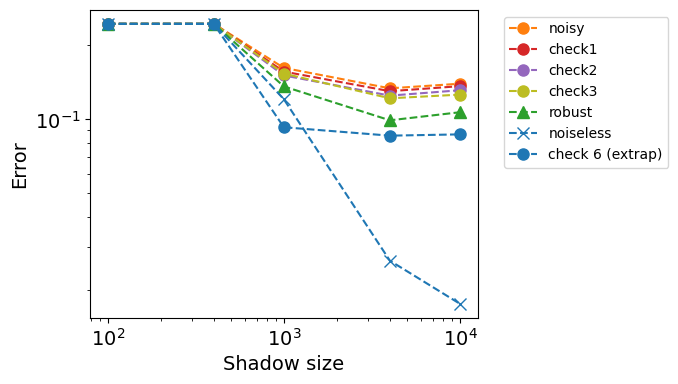

In [64]:
plt.figure(figsize=(5, 4), dpi=100)
plt.plot(shadow_range, error, '--o', ms=8, color='tab:orange', label='noisy')
plt.plot(shadow_range, error_check1, '--o', ms=8, color='tab:red', label='check1')
plt.plot(shadow_range, error_check2, '--o', ms=8, color='tab:purple', label='check2')
plt.plot(shadow_range, error_check3, '--o', ms=8, color='tab:olive', label='check3')
# plt.plot(shadow_range, error_check4, '--o', ms=8, color='tab:pink', label='check4')
plt.plot(shadow_range, error_r, '--^', ms=8, color='tab:green', label='robust')
plt.plot(shadow_range, error_noiseless, '--x', ms=8, color='tab:blue', label='noiseless')

# Plotting each layer of extrapolated checks
colors = ['tab:brown', 'tab:gray', 'tab:cyan', 'tab:pink', 'tab:purple'] 
for layer_index, layer in enumerate(extrapolation_layers):
    plt.plot(shadow_range, error_check_limit[layer_index, :],  '--o', ms=8, label=f'check {layer} (extrap)')

# Adjust the legend to be outside without altering the figure size
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xlabel('Shadow size', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=14)

# Note: The figure's layout isn't altered with plt.tight_layout() in this case
# Saving the figure with bbox_inches='tight' includes the external legend
plt.savefig('non_idealchecks.png', dpi=100, bbox_inches="tight")
plt.show()


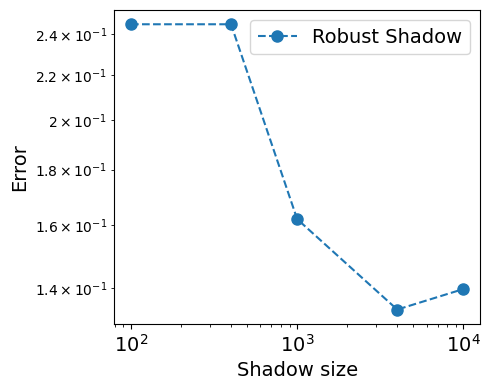

In [65]:
plt.figure(figsize=(5, 4), dpi=100)
plt.plot(shadow_range, error, '--o', ms=8, color='tab:blue', label='Robust Shadow')
plt.legend(fontsize=14, loc='best')
plt.xlabel('Shadow size', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()